In [1]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt

## 准备数据集

In [3]:
#如果网络能在GPU中训练，就使用GPU；否则使用CPU进行训练
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print('device: ', device)

#这个函数包括了两个操作：将图片转换为张量，以及将图片进行归一化处理
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                torchvision.transforms.Normalize(mean = [0.5],std = [0.5])])

device:  cuda:0


In [4]:
path = './data/'  #数据集下载后保存的目录

#下载训练集和测试集
trainData = torchvision.datasets.MNIST(path,train = True,transform = transform, download = True)
testData = torchvision.datasets.MNIST(path,train = False,transform = transform, download=True)

接下来创建好数据迭代器

In [5]:
#设定每一个Batch的大小
BATCH_SIZE = 256  

#构建数据集和测试集的DataLoader
trainDataLoader = torch.utils.data.DataLoader(dataset = trainData, batch_size = BATCH_SIZE,shuffle = True)
testDataLoader = torch.utils.data.DataLoader(dataset = testData, batch_size = BATCH_SIZE)


## 搭建网络

### 使用简单的全连接神经网络

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.fc_model = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
        self.classify = nn.Softmax(dim=1)
        # self.model = torch.nn.Sequential(
        #     #The size of the picture is 28x28
        #     torch.nn.Conv2d(in_channels = 1,out_channels = 16,kernel_size = 3,stride = 1,padding = 1),
        #     torch.nn.ReLU(),
        #     torch.nn.MaxPool2d(kernel_size = 2,stride = 2),
            
        #     #The size of the picture is 14x14
        #     torch.nn.Conv2d(in_channels = 16,out_channels = 32,kernel_size = 3,stride = 1,padding = 1),
        #     torch.nn.ReLU(),
        #     torch.nn.MaxPool2d(kernel_size = 2,stride = 2),
            
        #     #The size of the picture is 7x7
        #     torch.nn.Conv2d(in_channels = 32,out_channels = 64,kernel_size = 3,stride = 1,padding = 1),
        #     torch.nn.ReLU(),
            
        #     torch.nn.Flatten(),
        #     torch.nn.Linear(in_features = 7 * 7 * 64,out_features = 128),
        #     torch.nn.ReLU(),
        #     torch.nn.Linear(in_features = 128,out_features = 10),
        #     torch.nn.Softmax(dim=1)
        # )
        
    def forward(self, input: torch.TensorType):
        '''由于是灰度图，最开始的输入input尺寸为(batch_size, 1, 28, 28)'''
        x = torch.flatten(input, 1) # x: (batch_size, 28*28)
        output = self.fc_model(x)
        output = self.classify(output)
        return output

### 使用残差网络（深度卷积网络）

In [12]:
class ResBlk(nn.Module):

    def __init__(self, ch_in, ch_out, stride) -> None:
        super(ResBlk, self).__init__()

        self.conv1 = nn.Conv2d(ch_in, ch_out, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(ch_out)
        self.conv2 = nn.Conv2d(ch_out, ch_out, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(ch_out)

        self.extra = nn.Sequential()
        # 为了统一残差结构下的shortcut与卷积层输出的张量尺寸，需要提供一个额外的卷积层
        if ch_out != ch_in:
            self.extra = nn.Sequential(
                nn.Conv2d(ch_in, ch_out, kernel_size=1, stride=stride),
                nn.BatchNorm2d(ch_out)
            )

    
    def forward(self, x: torch.Tensor):
        '''
        x (batch_size, c, h, w)
        '''
        # print('in resBlock:', x.shape)
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn1(self.conv2(out)))
        # 加入shortcut，需要统一张量尺寸
        out = self.extra(x) + out
        return out


class ResNet(nn.Module):
    
    def __init__(self) -> None:
        super(ResNet, self).__init__()

        # 灰度图，通道数为1
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64)
        )
        # 接上4个block
        # (b, 64, h, w) => (b, 128, h, w)，以此类推
        self.blk1 = ResBlk(64, 128, stride=2)
        self.blk2 = ResBlk(128, 256, stride=2)
        self.blk3 = ResBlk(256, 512, stride=2)
        self.blk4 = ResBlk(512, 1024, stride=2)

        # 池化
        self.avg_pool = nn.AdaptiveAvgPool2d(1)

        # 全连接层
        self.outlayer = nn.Linear(1024, 10)
        # self.classifer = nn.Softmax()


    def forward(self, x: torch.Tensor):
        # print('at first:', x.shape)
        x = F.relu(self.conv1(x))
        # print('before resBlock1:', x.shape)
        x = self.blk1(x)
        # print('before resBlock2:', x.shape)
        x = self.blk2(x)
        x = self.blk3(x)
        x = self.blk4(x)

        # x = F.adaptive_avg_pool2d(x, output_size=[1, 1])
        # print('before pool: ', x.shape)
        # x = F.adaptive_avg_pool2d(x)
        x = self.avg_pool(x)
        # print('after pool: ', x.shape)
        x = x.view(x.size(0), -1)
        x = self.outlayer(x)
        return x

In [13]:
# net = Net()
net = ResNet()
net = net.to(device)
#将模型转换到device中，并将其结构显示出来
# print(net.to(device))

In [9]:
# torch.cuda.is_available()
torch.__version__

'1.12.1'

定义好损失函数和优化器

In [14]:
lossF = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters())

In [15]:
EPOCHS = 10
# 存储训练过程
history = {'Test Loss': [], 'Test Accuracy': []}
for epoch in range(1, EPOCHS + 1):
    # 添加一个进度条，增加可视化效果
    processBar = tqdm(trainDataLoader, unit='step')
    net.train(True)
    
    for step, (trainImgs, labels) in enumerate(processBar):
        trainImgs = trainImgs.to(device)
        labels = labels.to(device)

        net.zero_grad()
        outputs = net(trainImgs)
        loss = lossF(outputs, labels)
        predictions = torch.argmax(outputs, dim=1)
        accuracy = torch.sum(predictions == labels)/labels.shape[0]
        loss.backward()

        optimizer.step()
        processBar.set_description("[%d/%d] Loss: %.4f, Acc: %.4f" %
                                   (epoch, EPOCHS, loss.item(), accuracy.item()))

        if step == len(processBar)-1:
            correct, totalLoss = 0, 0
            net.train(False)
            for testImgs, labels in testDataLoader:
                testImgs = testImgs.to(device)
                labels = labels.to(device)
                outputs = net(testImgs)
                loss = lossF(outputs, labels)
                predictions = torch.argmax(outputs, dim=1)

                totalLoss += loss
                correct += torch.sum(predictions == labels)
            testAccuracy = correct/(BATCH_SIZE * len(testDataLoader))
            testLoss = totalLoss/len(testDataLoader)
            history['Test Loss'].append(testLoss.item())
            history['Test Accuracy'].append(testAccuracy.item())
            processBar.set_description("[%d/%d] Loss: %.4f, Acc: %.4f, Test Loss: %.4f, Test Acc: %.4f" %
                                       (epoch, EPOCHS, loss.item(), accuracy.item(), testLoss.item(), testAccuracy.item()))
    processBar.close()

[1/10] Loss: 0.1083, Acc: 0.9688: 100%|█████████▉| 234/235 [01:06<00:00,  3.51step/s]


RuntimeError: CUDA out of memory. Tried to allocate 50.00 MiB (GPU 0; 4.00 GiB total capacity; 3.35 GiB already allocated; 0 bytes free; 3.41 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

## 测试模型

In [36]:
# 构造临时变量
correct, totalLoss = 0, 0
# 关闭模型的训练状态
net.train(False)
# 对测试集的DataLoader进行迭代
for testImgs, labels in testDataLoader:
    # print('测试数据集: ', testImgs.shape)
    testImgs = testImgs.to(device)
    labels = labels.to(device)
    outputs = net(testImgs)
    loss = lossF(outputs, labels)

    # predictions: (256, )，刚好是当前批量每一个样本的预测结果
    predictions = torch.argmax(outputs, dim=1)
    print(
        f'current batch testing result, loss:{loss}, prediction {predictions.shape} ')
        
    # 存储测试结果
    totalLoss += loss
    correct += torch.sum(predictions == labels)

# 计算总测试的平均准确率
testAccuracy = correct/(BATCH_SIZE * len(testDataLoader))
print('average test accuracy: ', testAccuracy.item())
# 计算总测试的平均Loss
testLoss = totalLoss/len(testDataLoader)
print('total test loss: ', testLoss.item())
# 将本step结果进行可视化处理
processBar.set_description("[%d/%d] Loss: %.4f, Acc: %.4f, Test Loss: %.4f, Test Acc: %.4f" %
                           (epoch, EPOCHS, loss.item(), accuracy.item(), testLoss.item(), testAccuracy.item()))


current batch testing result, loss:1.4828433990478516, prediction torch.Size([256]) 
current batch testing result, loss:1.4907573461532593, prediction torch.Size([256]) 
current batch testing result, loss:1.4928758144378662, prediction torch.Size([256]) 
current batch testing result, loss:1.4851353168487549, prediction torch.Size([256]) 
current batch testing result, loss:1.508770227432251, prediction torch.Size([256]) 
current batch testing result, loss:1.5025616884231567, prediction torch.Size([256]) 
current batch testing result, loss:1.4927406311035156, prediction torch.Size([256]) 
current batch testing result, loss:1.4946931600570679, prediction torch.Size([256]) 
current batch testing result, loss:1.5097918510437012, prediction torch.Size([256]) 
current batch testing result, loss:1.4901165962219238, prediction torch.Size([256]) 
current batch testing result, loss:1.4977720975875854, prediction torch.Size([256]) 
current batch testing result, loss:1.4999380111694336, prediction 

## 训练结果、测试结果可视化

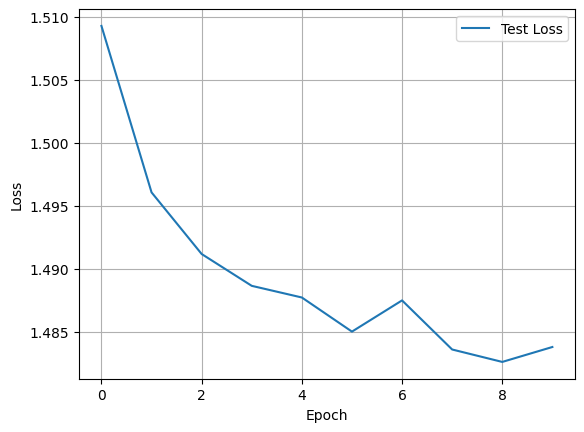

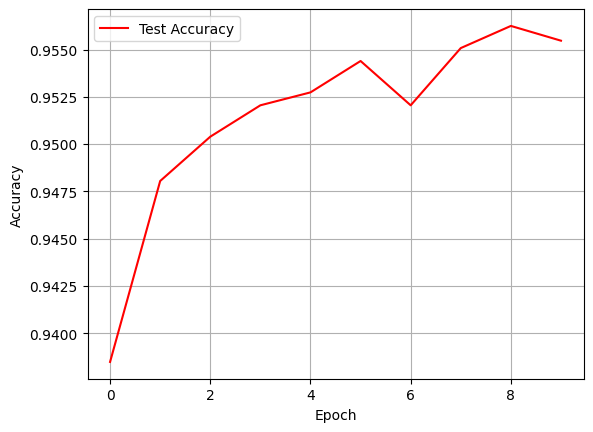

In [37]:
#对测试Loss进行可视化
plt.plot(history['Test Loss'],label = 'Test Loss')
plt.legend(loc='best')
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

#对测试准确率进行可视化
plt.plot(history['Test Accuracy'],color = 'red',label = 'Test Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()